<a href="https://colab.research.google.com/github/rubanzasilva/customer_transaction_prediction/blob/master/santander_customer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SANTANDER SOLUTION

We want to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.
We want to be able to work with  binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

In this challenge we want to be able to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted.
The data provided for this competition has the same structure as the real data we have available to solve this problem.



In [0]:
# Install fastai
!pip3 install fastai

    100% |████████████████████████████████| 17.3MB 2.3MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [4]:
import sys
sys.version

'3.6.7 (default, Oct 22 2018, 11:32:17) \n[GCC 8.2.0]'

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import seaborn as sns
from pathlib import Path
import PIL
import json
from fastai import *
from fastai.tabular import *
from fastai.vision import *
from fastai.metrics import error_rate


                                               **LOADING KAGGLE DATASET **
        
---



In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yngspacecadet","key":"1e8d5f52cfacd4df7a24c5932f6514d9"}'}

In [0]:
 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [0]:
# This permissions change avoids a warning on Kaggle tool startup.
#Change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
# List available datasets.
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          26687  
noriuk/us-education-datasets-unification-project             U.S. Education Datasets: Unification Project         85MB  2019-03-02 18:41:52           3169  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25          19670  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59          21099  
vjchoudhary7/customer-segmentation-tutorial-in-python     

In [13]:
!kaggle competitions download -c santander-customer-transaction-prediction  -p /content/kaggle --force


100% 122M/122M [00:01<00:00, 114MB/s] 
100% 122M/122M [00:01<00:00, 110MB/s]
  0% 0.00/463k [00:00<?, ?B/s]
100% 463k/463k [00:00<00:00, 110MB/s]
 91% 111M/122M [00:01<00:00, 85.1MB/s] 
100% 122M/122M [00:01<00:00, 109MB/s] 


In [14]:
PATH = Path('content/kaggle/')
PATH


PosixPath('content/kaggle')

In [15]:
!unzip kaggle/train.csv.zip

Archive:  kaggle/train.csv.zip
  inflating: train.csv               


In [16]:
!unzip kaggle/test.csv.zip

Archive:  kaggle/test.csv.zip
  inflating: test.csv                


In [17]:
!unzip kaggle/sample_submission.csv.zip

Archive:  kaggle/sample_submission.csv.zip
  inflating: sample_submission.csv   


                                                               **LOAD DATA INTO DATAFRAME**

In [0]:
train_df = pd.read_csv('/content/train.csv')

In [0]:
test_df = pd.read_csv('test.csv')

In [0]:
ss_df = pd.read_csv('sample_submission.csv')

In [0]:
train_df.head()

In [0]:
test_df.head(10)

In [0]:
ss_df.head(5)

In [0]:
train_df.describe()

In [0]:
test_df.describe()

In [0]:
#dataframe size rows * columns
size = train_df.size
size

In [0]:
size1 = test_df.size
size1

In [0]:
#dataframe shape
shape = train_df.shape
shape

In [0]:
shape1 = test_df.shape
shape1

In [0]:
dim = train_df.ndim
dim

In [0]:
len(train_df),len(test_df)

                                                 ** DATA PRE-PROCESSING**

In [0]:
dep_var = 'target'

In [0]:
cat_names = []

In [0]:
df = train_df

In [0]:
cont_names = []
var_counter = 0 #creating a counter
num_of_cont_vars = len(df.columns) - 2
for _ in range(num_of_cont_vars):
    name = 'var_' + str(var_counter)
    cont_names.append(name)
    var_counter+=1

In [0]:
procs = [FillMissing, Normalize]

In [0]:
valid_idx = range(len(df)-20000, len(df))

In [0]:
test = TabularList.from_df(test_df, path=PATH, cont_names=cont_names, procs=procs)

In [43]:
path = PATH

data = (TabularList.from_df(df, path=path, cont_names=cont_names, procs=procs)
        .split_by_rand_pct(valid_pct=0.1)
        .label_from_df(cols=dep_var)
        .add_test(test)
        .databunch())

print(data.train_ds.cont_names)

['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 'var_10', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15', 'var_16', 'var_17', 'var_18', 'var_19', 'var_20', 'var_21', 'var_22', 'var_23', 'var_24', 'var_25', 'var_26', 'var_27', 'var_28', 'var_29', 'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39', 'var_40', 'var_41', 'var_42', 'var_43', 'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49', 'var_50', 'var_51', 'var_52', 'var_53', 'var_54', 'var_55', 'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65', 'var_66', 'var_67', 'var_68', 'var_69', 'var_70', 'var_71', 'var_72', 'var_73', 'var_74', 'var_75', 'var_76', 'var_77', 'var_78', 'var_79', 'var_80', 'var_81', 'var_82', 'var_83', 'var_84', 'var_85', 'var_86', 'var_87', 'var_88', 'var_89', 'var_90', 'var_91', 'var_92', 'var_93', 'var_94', 'var_95', 'var_96', 'var_97', 'var_98', 'var_99', 'var_100'

In [45]:
data.show_batch(rows= 6)

var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
-0.8427,0.1476,1.1888,0.2811,-0.7799,0.7877,-0.1885,1.2641,-1.1168,0.7042,-1.1258,0.5009,-0.6744,0.8326,-0.2204,0.1577,-1.3309,0.7772,-1.2463,0.3462,1.1192,-0.4166,0.4391,-0.9086,-0.0052,-0.6649,0.4071,0.3978,-1.3909,1.8647,-1.7785,-1.3893,0.2582,0.8050,-0.8307,-0.5048,1.3213,-0.4027,-0.8623,-0.9155,0.4652,0.6417,0.2404,1.9486,0.7725,0.7901,0.4864,-1.3563,0.2872,0.5691,-0.5479,1.5478,0.5597,-0.3350,-1.0701,-0.5404,0.3385,0.0196,-0.9458,-0.0364,1.8638,1.6580,-0.5591,-0.9660,0.8448,0.4325,-0.1758,-0.4754,-0.6815,0.5518,-0.5327,0.0759,0.7837,-0.5032,0.2655,0.5843,1.1043,0.2027,-1.2989,-1.8646,-0.6912,0.9181,1.2961,0.6020,0.1757,0.9791,-2.0372,-0.0885,-0.6943,0.1306,0.5527,-0.0180,0.2588,-0.8469,0.5424,1.1928,-0.3021,1.3340,0.3461,-0.0956,-1.1862,-0.1236,1.2926,-0.3346,0.1571,-0.7795,0.3001,0.7807,-0.7112,1.9336,0.2777,0.8298,0.5116,-0.6865,1.5812,1.2559,-2.1481,-1.8032,-0.2482,-0.5163,-1.1897,-1.4698,0.9954,0.3153,0.9289,0.1191,1.8680,0.2193,0.0497,0.6022,0.2462,0.0477,-1.2198,0.5356,1.9597,0.0741,-0.0709,1.5046,0.9343,-1.2254,1.2373,-1.3449,-0.2354,-1.6629,1.8989,0.0021,-1.4517,-1.0844,-0.2664,-1.8894,-0.7461,0.6813,0.0904,0.0262,-1.2149,1.3218,1.2718,1.0264,0.2963,0.9393,1.4330,0.9018,-1.3202,-1.3004,0.8550,0.4311,-0.0036,1.1024,0.7067,-0.4712,0.8183,2.3393,-0.1332,-0.6255,-0.7724,-0.6240,1.1454,0.2419,-0.6072,1.5165,-0.1688,-0.4139,1.0530,-1.1199,1.9451,-0.4403,1.5987,-0.9850,-1.6279,-0.2998,-0.3502,-1.2386,-0.1685,1.1615,2.1349,0.4011,-0.6313,1.8581,1.3437,-0.0273,0
0.5433,-0.1449,0.7250,-0.8484,0.4099,-1.5859,-0.6733,-1.5815,-0.8060,-0.4308,-0.8460,-0.0755,0.8820,0.4125,1.1666,1.9802,-1.8927,1.2247,-0.1295,1.3383,0.5614,1.0435,-1.0129,0.1008,-1.0554,0.4894,-1.2347,-2.4546,-1.0282,-0.4411,0.9417,-0.6691,0.9900,1.0262,-0.3657,-0.3542,0.4760,-0.9321,-1.6460,-0.0731,2.2609,-0.1362,1.1989,-1.1663,1.4409,1.5811,-0.1351,-0.5598,-0.2327,-1.4492,1.4698,1.4442,-0.6881,-0.3976,-1.0910,-1.7757,0.6030,1.7131,0.4454,1.2291,-1.7618,0.2991,0.3471,-1.5134,1.7592,-0.9497,0.6313,1.1986,-0.1805,-0.1172,0.0627,-1.4522,1.3863,0.1236,2.1817,0.4172,-0.5412,0.2268,-0.9595,-1.4361,0.5732,-1.6627,-1.1519,-2.1002,0.4853,-0.6766,0.1995,1.6842,0.8592,-0.0831,0.3039,2.2639,1.5453,0.4693,-0.7960,-1.8111,0.7187,0.7637,-0.7480,-0.4982,0.1733,0.4895,1.3579,-1.9901,0.0119,0.4875,-1.3710,-0.6296,-0.8135,-0.6886,0.5157,0.6561,0.2390,1.5936,0.3820,-0.4576,0.7218,0.1602,-0.7770,-1.8380,-1.9860,0.1351,-0.4825,1.4904,2.1053,-1.3007,2.0135,0.4046,0.9445,-0.9860,0.9614,-0.2279,-0.8182,-0.8494,-0.7034

In [47]:
(cat_x,cont_x),y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(to_np(o[:5]))

[0 0 0 0 0]
[[ 0.936406 -0.090088  0.445934 -1.205792 ...  0.083476 -1.01882   0.480506  0.354533]
 [-0.91344  -0.635152 -0.671581 -0.670891 ... -0.598397 -0.427831  1.171419  0.667207]
 [ 0.798999  1.622511 -0.09564  -0.458596 ...  0.013203  0.573247 -0.253783  1.42021 ]
 [ 1.302704 -0.572514  0.520579 -0.073125 ...  0.784319  1.031952 -0.174013  0.322833]
 [ 0.852784  1.075916  1.058591 -0.069747 ...  0.76073   1.945239 -1.517716 -1.206519]]
[0 0 0 0 0]


                                            **DEFINING AND TRAIN  MODEL**

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [0]:
learn = tabular_learner(data, layers=[1000, 500, 200], ps=[0.001,0.01,0.1], emb_drop=0.04, emb_szs={'ID_code': 20}, metrics=accuracy)
#to change to get rsqme just change accuracy to rmspe
# ps=[0.001,0.01], emb_drop=0.09,  emb_szs={'ID_code': 10},

In [51]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=200, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=200, bias=True)
    (9): ReLU(inplace)
    (10): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1)
    (12): Linear(in_features=200, out_features=2, bias=True)
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


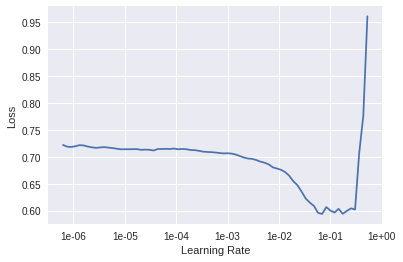

In [52]:
learn.lr_find()
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(7, 0.01 , wd = 0.3)
#wd=0.2

epoch,train_loss,valid_loss,accuracy,time
0,0.240605,0.248154,0.909300,00:45
1,0.269596,0.274281,0.896000,00:46
2,0.261834,0.264763,0.896900,00:46
3,0.246859,0.269692,0.904050,00:46
4,0.260443,0.258047,0.907450,00:46
5,0.253607,0.242154,0.909350,00:47
6,0.232978,0.237706,0.910950,00:45


In [54]:
learn.show_results()

var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target,prediction
-1.6011,0.6833,-0.1052,0.2642,0.7334,1.1855,0.9718,-0.0063,-1.1869,0.4895,0.6718,-1.2261,-0.4788,0.7156,-0.1495,0.6797,0.5702,1.1877,-0.5608,-0.3295,-0.0383,1.8597,-0.0939,0.3356,1.8530,0.6571,-0.4508,1.4425,-0.9200,-1.6517,-0.3593,-2.0711,0.3463,1.2109,-0.0891,-1.0036,-1.9380,2.2947,-1.6832,-0.4895,0.0507,-0.7784,-1.5577,-0.5650,0.6755,0.7350,0.1862,-1.7750,-1.0245,-0.1502,-0.6412,-0.1889,0.1710,-1.1713,0.8829,-1.6682,-0.8585,0.4576,0.2613,0.5964,-0.8328,1.1518,0.0500,1.0124,0.7042,0.1596,1.7787,1.8258,-0.1945,-1.1738,1.8079,1.1943,-0.0554,0.3565,1.9292,0.9670,0.2280,-0.3552,0.0106,-1.3706,0.3010,0.9657,-0.7941,-0.4967,-0.0737,-1.5587,0.0412,-0.5724,-0.5052,-0.7027,0.4098,0.2285,-1.3442,-1.3171,-1.5448,-0.1754,-1.0430,-0.3365,-1.0954,-0.8013,1.0061,1.2445,0.1931,1.1295,-0.6586,1.8803,-1.4613,0.5221,-0.1652,-1.3660,-0.1566,-0.6558,-1.0046,1.4552,-0.4938,0.2070,0.6587,0.8138,0.3158,-1.1980,0.3966,0.6393,0.4830,-1.8518,0.6743,-0.7052,1.4101,-1.3011,-0.0603,1.2784,0.5728,1.2581,-1.3776,0.2342,-0.4131,-1.7677,-0.2651,0.2138,0.4541,-0.4192,-1.4257,-0.5241,0.3159,-0.2420,-0.1075,-0.8198,-0.0467,-0.3900,1.5364,-1.6992,0.6724,1.4525,-0.8417,-0.7758,0.9330,-0.4510,-1.2636,-1.2096,-0.2017,0.4938,0.6679,1.6668,0.3675,-0.3049,-0.3799,0.0303,-0.3579,1.5451,0.1664,0.3783,1.0291,-1.3127,0.3922,1.7484,-0.4343,0.5384,-0.7661,-2.0284,0.2927,-0.7179,-0.2458,0.2095,-1.0928,0.4735,-0.9016,1.0070,1.2234,0.6925,-0.5353,-0.9463,-0.6973,0.9354,0.7886,0.1871,0.0157,-0.4218,0.1047,0.3742,1.3676,1.4660,0,0
0.0465,0.2150,-0.3560,-0.3920,-0.4545,-0.1853,-0.7971,0.4958,-1.7386,-0.3455,-0.0763,0.4201,0.9361,-0.2203,-0.4775,-1.1838,2.1177,0.8387,1.2687,0.5323,0.9076,0.3906,-0.3857,1.9001,-0.2020,-0.3670,1.6316,-1.5649,-1.1496,-0.6876,1.3675,0.0414,-0.1143,-0.9817,1.2440,-1.1634,-0.6062,-0.3917,-1.1173,0.0722,0.9360,0.0121,1.1690,-1.1150,0.9239,0.0617,1.1379,0.7170,-0.9909,0.4181,0.1924,-0.1220,-0.4808,1.2681,-1.1109,1.1476,-0.8363,-0.9302,-0.0534,0.5879,0.1813,0.1800,0.3375,-0.0979,0.3778,0.1763,-0.2228,-0.6357,-0.6120,1.1690,1.6224,-1.6801,0.4453,-0.4240,0.2275,0.2456,1.7986,0.6120,-0.7734,1.3211,0.6550,-1.1347,-0.6710,-0.6033,-1.5242,-0.1214,-0.8287,-0.4065,0.0076,2.5210,-0.7069,-0.6814,-0.2036,-0.3037,0.8498,0.2946,1.0620,0.1388,0.1372,-0.1874,1.0106,-0.4051,-0.0706,-0.6540,0.4769,-1.1187,0.7616,1.0681,0.2796,0.4074,0.5155,0.4507,-0.5105,-1.2065,-1.0063,-0.3078,-1.1139,-0.0057,-0.2347,-0.8512,2.3471,0.8278,-0.9206,-0.2619,0.7727,1.2882,-0.3306,-0.5546,1.7720,0.6189,1.6417,1.050

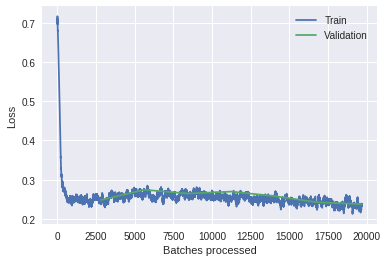

In [55]:
learn.recorder.plot_losses()

In [0]:
learn.data.batch_size

64

In [56]:
test_preds = learn.get_preds(ds_type=DatasetType.Test)
test_preds

[tensor([[0.8022, 0.1978],
         [0.7255, 0.2745],
         [0.9440, 0.0560],
         ...,
         [0.9960, 0.0040],
         [0.9487, 0.0513],
         [0.8655, 0.1345]]), tensor([0, 0, 0,  ..., 0, 0, 0])]

In [0]:
target_preds = test_preds[0][:,1]
test_df['target'] = target_preds

In [58]:
target_preds

tensor([0.1978, 0.2745, 0.0560,  ..., 0.0040, 0.0513, 0.1345])

In [0]:
path = PATH
test_df.to_csv(path/'submission.csv', columns=['ID_code', 'target'], index=False)

In [60]:
sub = pd.read_csv(PATH/'submission.csv')
sub.head()

,ID_code,target
0,test_0,0.197758
1,test_1,0.274475
2,test_2,0.055971
3,test_3,0.227458
4,test_4,0.059754


In [0]:
preds = learn.get_preds()
pred_tensors = preds[0]
actual_labels = preds[1].numpy()

In [62]:
pred_tensors, actual_labels

total_to_test = 20000
correct = 0
for i in range(total_to_test):
    if(pred_tensors[i][0] > 0.5 and actual_labels[i] == 0):
        correct = correct + 1

print(f"{correct}/{total_to_test} correct")

17708/20000 correct


In [0]:
learn.save("trained_model", return_path=True)

PosixPath('content/kaggle/models/trained_model.pth')

In [0]:
learn = learn.load("trained_model" )

In [63]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f {PATH/'submission.csv'} -m "initial submission"

100% 4.37M/4.37M [00:01<00:00, 2.83MB/s]
Successfully submitted to Santander Customer Transaction Prediction

In [64]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197,0.197757
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760,0.274475
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794,0.055971
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108,0.227458
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846,0.059754
